<a href="https://colab.research.google.com/github/MesquitaALucas/Scketchbook/blob/main/C%C3%B3pia_de_TP2_ICV_V2_REDE_DE_DUAS_CONVOLU%C3%87%C3%95ES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/amandaxm/icv-reconhecimento-captcha

fatal: destination path 'icv-reconhecimento-captcha' already exists and is not an empty directory.


In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd

# CNN
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical

# MNIST
from keras.datasets import mnist

# plot
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import svm

from skimage.feature import hog

from sklearn.metrics import classification_report,accuracy_score

np.random.seed(123)  # for reproducibility

In [3]:
path_labels = 'icv-reconhecimento-captcha/labels10k/'
path_train = 'icv-reconhecimento-captcha/treinamento/'
path_validation = 'icv-reconhecimento-captcha/validacao/'
path_test = 'icv-reconhecimento-captcha/teste/'

In [4]:
def get_images(path):
  images = dict()
  for filename in os.listdir(path):
    images[filename.split('.')[0]] = Image.open(path + '/' + filename)
  return images

In [5]:
images_train = get_images(path_train)
images_validation = get_images(path_validation)
images_test = get_images(path_test)

In [6]:
labels = dict()
for filename in os.listdir(path_labels):
  with open(path_labels + '/' + filename) as f: label = f.read().replace('\n', '')
  labels[filename.split('.')[0]] = label

In [7]:
df_train = pd.DataFrame(images_train.items(), columns=['File', 'Image'])

In [8]:
df_validation = pd.DataFrame(images_validation.items(), columns=['File', 'Image'])

In [9]:
df_test = pd.DataFrame(images_test.items(), columns=['File', 'Image'])

In [10]:
df_dict = {
    'train': df_train,
    'validation': df_validation,
    'test': df_test,
}

In [11]:
df = pd.concat([df.assign(Subset=k) for k,df in df_dict.items()]).sort_values('File')

In [12]:
df

,File,Image,Subset
6917,000001,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train
4955,000002,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train
1991,000003,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train
1705,000004,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train
82,000005,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train
...,...,...,...
184,009996,<PIL.JpegImagePlugin.JpegImageFile image mode=...,test
297,009997,<PIL.JpegImagePlugin.JpegImageFile image mode=...,test
25,009998,<PIL.JpegImagePlugin.JpegImageFile image mode=...,test
380,009999,<PIL.JpegImagePlugin.JpegImageFile image mode=...,test


In [13]:
df_labels = pd.DataFrame(labels.items(), columns=['File', 'Label'])

In [14]:
df_labels

,File,Label
0,009237,49YIRU
1,009976,AOUAYT
2,004307,JD1C1C
3,002988,EVNJJX
4,006869,93WDFT
...,...,...
9995,004061,DEVN4B
9996,004038,M3U9W8
9997,001594,GBUJU8
9998,002517,8NUXEI


In [15]:
df = pd.merge(df, df_labels, on='File')

In [16]:
df

,File,Image,Subset,Label
0,000001,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,RNINIC
1,000002,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,TVCFS8
2,000003,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,N1O1EH
3,000004,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,OQZSL4
4,000005,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,GST2YA
...,...,...,...,...
9995,009996,<PIL.JpegImagePlugin.JpegImageFile image mode=...,test,66ZDPA
9996,009997,<PIL.JpegImagePlugin.JpegImageFile image mode=...,test,2044B3
9997,009998,<PIL.JpegImagePlugin.JpegImageFile image mode=...,test,SNB9SO
9998,009999,<PIL.JpegImagePlugin.JpegImageFile image mode=...,test,0DTW1D


In [17]:
not_len_6_df = df[df['Label'].str.len() != 6]

In [18]:
contains_question_df = df[df['Label'].str.contains('\?') == True]

In [19]:
not_len_6_df['Subset'].value_counts()

,count
Subset,
train,3
validation,1
test,1


In [20]:
contains_question_df['Subset'].value_counts()

,count
Subset,
train,98


In [21]:
df = df[df['Label'].str.contains('\?') == False]
df = df[df['Label'].str.len() == 6]

In [22]:
df['Image_array_1'] = df['Image'].apply(lambda image: (np.asarray(image) > 128).astype(int)[:, 12:, 0])
df['Image_array_2'] = df['Image_array_3'] = df['Image_array_4'] = df['Image_array_5'] = df['Image_array_6'] = df['Image_array_1']

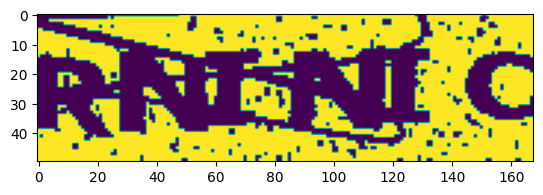

In [23]:
plt.imshow(df['Image_array_1'][0])

In [24]:
for i in range(6):
  df[f'Image_array_{i+1}'] = df[f'Image_array_{i+1}'].apply(lambda array: array[:, 28*i:28*i+28])

In [25]:
labels_to_int = dict()

In [26]:
for i in range(10):
  labels_to_int[str(i)] = i

for i in range(26):
  labels_to_int[chr(ord('A') + i)] = 10 + i

In [27]:
df['Label_int_1'] = df['Label'].apply(lambda label: [*label]).apply(lambda l: np.array(list(map(labels_to_int.get, l))))
df['Label_int_2'] = df['Label_int_3'] = df['Label_int_4'] = df['Label_int_5'] = df['Label_int_6'] = df['Label_int_1']

In [28]:
for i in range(6):
  df[f'Label_int_{i+1}'] = df[f'Label_int_{i+1}'].apply(lambda l: l[i])

In [29]:
df.head()

,File,Image,Subset,Label,Image_array_1,Image_array_2,Image_array_3,Image_array_4,Image_array_5,Image_array_6,Label_int_1,Label_int_2,Label_int_3,Label_int_4,Label_int_5,Label_int_6
0,000001,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,RNINIC,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,...",27,23,18,23,18,12
1,000002,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,TVCFS8,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",29,31,12,15,28,8
2,000003,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,N1O1EH,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",23,1,24,1,14,17
3,000004,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,OQZSL4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",24,26,35,28,21,4
4,000005,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,GST2YA,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",16,28,29,2,34,10


In [30]:
X_train =       np.array([np.array(list(df[df['Subset'] == 'train'][f'Image_array_{i+1}'])) for i in range(6)])
X_test =        np.array([np.array(list(df[df['Subset'] == 'test'][f'Image_array_{i+1}'])) for i in range(6)])
X_validation =  np.array([np.array(list(df[df['Subset'] == 'validation'][f'Image_array_{i+1}'])) for i in range(6)])
Y_train =       np.array([np.array(list(df[df['Subset'] == 'train'][f'Label_int_{i+1}'])) for i in range(6)])
Y_test =        np.array([np.array(list(df[df['Subset'] == 'test'][f'Label_int_{i+1}'])) for i in range(6)])
Y_validation =  np.array([np.array(list(df[df['Subset'] == 'validation'][f'Label_int_{i+1}'])) for i in range(6)])

In [31]:
X_train_left = X_train[0]
X_train_center = X_train[1:-1]
X_train_right = X_train[-1]

X_test_left = X_test[0]
X_test_center = X_test[1:-1]
X_test_right = X_test[-1]

X_validation_left = X_validation[0]
X_validation_center = X_validation[1:-1]
X_validation_right = X_validation[-1]

Y_train_left = Y_train[0]
Y_train_center = Y_train[1:-1]
Y_train_right = Y_train[-1]

Y_test_left = Y_test[0]
Y_test_center = Y_test[1:-1]
Y_test_right = Y_test[-1]

Y_validation_left = Y_validation[0]
Y_validation_center = Y_validation[1:-1]
Y_validation_right = Y_validation[-1]

In [32]:
a, b, c, d = X_train_center.shape
X_train_center = X_train_center.reshape((a*b, c, d))
a, b, c, d = X_test_center.shape
X_test_center = X_test_center.reshape((a*b, c, d))
a, b, c, d = X_validation_center.shape
X_validation_center = X_validation_center.reshape((a*b, c, d))
a, b = Y_train_center.shape
Y_train_center = Y_train_center.reshape((a*b))
a, b = Y_test_center.shape
Y_test_center = Y_test_center.reshape((a*b))
a, b = Y_validation_center.shape
Y_validation_center = Y_validation_center.reshape((a*b))

In [33]:
category_count = len(labels_to_int)

Y_train_left_categorical = to_categorical(Y_train_left, category_count)
Y_train_center_categorical = to_categorical(Y_train_center, category_count)
Y_train_right_categorical = to_categorical(Y_train_right, category_count)

Y_test_left_categorical = to_categorical(Y_test_left, category_count)
Y_test_center_categorical = to_categorical(Y_test_center, category_count)
Y_test_right_categorical = to_categorical(Y_test_right, category_count)

Y_validation_left_categorical = to_categorical(Y_validation_left, category_count)
Y_validation_center_categorical = to_categorical(Y_validation_center, category_count)
Y_validation_right_categorical = to_categorical(Y_validation_right, category_count)

# Convolucional

## Left

In [34]:
# Sequential layer
model = Sequential()

In [35]:
# CNN input layer
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(50,28,1)))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
# hiden layers
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.25))

In [37]:
# fully connected layer
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(category_count, activation='softmax'))

In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 50, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 25, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 25, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 7, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 13, 7, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2912)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          93,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 36)                  │           1,188 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113,220 (442.27 KB)

 Trainable params: 113,220 (442.27 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [40]:
# response = model.fit(X_train_left, Y_train_left_categorical,
#           batch_size=128, epochs=5, verbose=1)
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3, # Número de épocas sem melhoria para parar o treinamento
                               restore_best_weights=True) # Restaurar os pesos do melhor modelo

response = model.fit(X_train_left, Y_train_left_categorical,
                     batch_size=128, epochs=100, verbose=1,
                     validation_data=(X_validation_left, Y_validation_left_categorical),
                     callbacks=[early_stopping])

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 628ms/step - accuracy: 0.0323 - loss: 3.5852 - val_accuracy: 0.0851 - val_loss: 3.4827
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 627ms/step - accuracy: 0.0735 - loss: 3.3614 - val_accuracy: 0.3133 - val_loss: 2.5476
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 39s 638ms/step - accuracy: 0.1873 - loss: 2.7750 - val_accuracy: 0.6386 - val_loss: 1.6654
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 36s 578ms/step - accuracy: 0.2860 - loss: 2.3313 - val_accuracy: 0.7407 - val_loss: 1.2714
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 583ms/step - accuracy: 0.3244 - loss: 2.1398 - val_accuracy: 0.8428 - val_loss: 1.0059
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 673ms/step - accuracy: 0.3804 - loss: 1.9352 - val_accuracy: 0.8458 - val_loss: 0.7963
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 38s 613ms/step - accuracy: 0.4069 - loss: 1.7929 - val_accuracy: 0.8859 - val_loss: 0.6279
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 39s 628ms/step - accuracy: 0.4505 - loss: 1.6451 - 

In [41]:
score = model.evaluate(X_test_left, Y_test_left_categorical, verbose=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9631 - loss: 0.1890


In [42]:
score = model.evaluate(X_validation_left, Y_validation_left_categorical, verbose=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9765 - loss: 0.1474


In [ ]:
print(score)

[1.4105511903762817, 0.7527527809143066]


## Center

In [43]:
# Sequential layer
model = Sequential()

In [44]:
# CNN input layer
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(50,28,1)))

In [45]:
# hiden layers
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.25))

In [46]:
# fully connected layer
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(category_count, activation='softmax'))

In [47]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 50, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 50, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 25, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 25, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 13, 7, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 13, 7, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 13, 7, 32)           │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 7, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 896)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │          28,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 36)                  │           1,188 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,956 (226.39 KB)

 Trainable params: 57,956 (226.39 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [53]:
# response = model.fit(X_train_center, Y_train_center_categorical,
#           batch_size=128, epochs=5, verbose=1)

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3, # Número de épocas sem melhoria para parar o treinamento
                               restore_best_weights=True) # Restaurar os pesos do melhor modelo

response = model.fit(X_train_center, Y_train_center_categorical,
                     batch_size=128, epochs=100, verbose=1,
                     validation_data=(X_validation_center, Y_validation_center_categorical),
                     callbacks=[early_stopping])

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 178s 720ms/step - accuracy: 0.5529 - loss: 1.5275 - val_accuracy: 0.8849 - val_loss: 0.4073
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 182s 639ms/step - accuracy: 0.6545 - loss: 1.0212 - val_accuracy: 0.9079 - val_loss: 0.3241
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 201s 633ms/step - accuracy: 0.6842 - loss: 0.9250 - val_accuracy: 0.9194 - val_loss: 0.2991
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 201s 630ms/step - accuracy: 0.6984 - loss: 0.8723 - val_accuracy: 0.9237 - val_loss: 0.2722
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 226s 726ms/step - accuracy: 0.7131 - loss: 0.8240 - val_accuracy: 0.9254 - val_loss: 0.2636
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 176s 624ms/step - accuracy: 0.7219 - loss: 0.8016 - val_accuracy: 0.9337 - val_loss: 0.2593
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 205s 636ms/step - accuracy: 0.7357 - loss: 0.7626 - val_accuracy: 0.9342 - val_loss: 0.2394
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 199s 625ms/step - accuracy: 

In [54]:
score = model.evaluate(X_test_center, Y_test_center_categorical, verbose=1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9621 - loss: 0.1581


In [55]:
score = model.evaluate(X_validation_center, Y_validation_center_categorical, verbose=1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9635 - loss: 0.1495


In [56]:
print(score)

[0.1748201698064804, 0.9552052021026611]


## Right

In [57]:
# Sequential layer
model = Sequential()

In [58]:
# CNN input layer
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(50,28,1)))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [59]:
# hiden layers
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.25))

In [60]:
# fully connected layer
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(category_count, activation='softmax'))

In [61]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 50, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 50, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 25, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 25, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 25, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 13, 7, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 13, 7, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 13, 7, 32)           │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 7, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 7, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 896)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │          28,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 36)                  │           1,188 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,956 (226.39 KB)

 Trainable params: 57,956 (226.39 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [63]:
# response = model.fit(X_train_right, Y_train_right_categorical,
#           batch_size=128, epochs=5, verbose=1)

# response = model.fit(X_train_center, Y_train_center_categorical,
#           batch_size=128, epochs=5, verbose=1)

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3, # Número de épocas sem melhoria para parar o treinamento
                               restore_best_weights=True) # Restaurar os pesos do melhor modelo

response = model.fit(X_train_right, Y_train_right_categorical,
                     batch_size=128, epochs=100, verbose=1,
                     validation_data=(X_validation_right, Y_validation_right_categorical),
                     callbacks=[early_stopping])

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 637ms/step - accuracy: 0.0259 - loss: 3.5859 - val_accuracy: 0.0230 - val_loss: 3.5693
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 628ms/step - accuracy: 0.0500 - loss: 3.5055 - val_accuracy: 0.3103 - val_loss: 2.8591
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 43s 661ms/step - accuracy: 0.1876 - loss: 2.8283 - val_accuracy: 0.6116 - val_loss: 1.6127
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 597ms/step - accuracy: 0.3682 - loss: 2.1051 - val_accuracy: 0.7848 - val_loss: 1.0358
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 43s 631ms/step - accuracy: 0.4743 - loss: 1.6864 - val_accuracy: 0.8478 - val_loss: 0.7742
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 619ms/step - accuracy: 0.5037 - loss: 1.5350 - val_accuracy: 0.8569 - val_loss: 0.6389
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 43s 661ms/step - accuracy: 0.5602 - loss: 1.3593 - val_accuracy: 0.8829 - val_loss: 0.5693
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 39s 625ms/step - accuracy: 0.5900 - loss: 1.2521 - 

In [64]:
score = model.evaluate(X_test_right, Y_test_right_categorical, verbose=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9306 - loss: 0.2574


In [65]:
print(score)

[0.25969627499580383, 0.9289289116859436]


# HOG

In [ ]:
for i in range(6):
  i = i + 1
  fds = list()
  hog_images = list()
  for image in df[f'Image_array_{i}']:
    fd, hog_image = hog(
      image,
      orientations=8,
      pixels_per_cell=(10, 10),
      cells_per_block=(1, 1),
      visualize=True,
    )
    fds.append(fd)
    hog_images.append(hog_image)
  df[f'fd_{i}'] = fds
  df[f'hog_image_{i}'] = hog_images

In [ ]:
fd_train =       np.array([np.array(list(df[df['Subset'] == 'train'][f'fd_{i+1}'])) for i in range(6)])
fd_test =        np.array([np.array(list(df[df['Subset'] == 'test'][f'fd_{i+1}'])) for i in range(6)])
fd_validation =  np.array([np.array(list(df[df['Subset'] == 'validation'][f'fd_{i+1}'])) for i in range(6)])

In [ ]:
fd_train_left = fd_train[0]
fd_test_left = fd_test[0]
fd_validation_left = fd_validation[0]

In [ ]:
clf = svm.SVC()

In [ ]:
clf.fit(fd_train_left, Y_train_left)

SVC()

In [ ]:
Y_pred_left = clf.predict(fd_test_left)

In [ ]:
print("Accuracy: "+str(accuracy_score(Y_test_left, Y_pred_left)))
print('\n')
print(classification_report(Y_test_left, Y_pred_left))

Accuracy: 0.3913913913913914


              precision    recall  f1-score   support

           0       0.38      0.38      0.38        34
           1       0.41      0.35      0.38        20
           2       0.35      0.54      0.42        28
           3       0.50      0.37      0.42        30
           4       0.60      0.70      0.65        30
           5       0.48      0.43      0.45        28
           6       0.27      0.42      0.33        24
           7       0.33      0.44      0.38        27
           8       0.34      0.73      0.46        26
           9       0.30      0.50      0.37        24
          10       0.44      0.70      0.54        23
          11       0.17      0.25      0.20        20
          12       0.18      0.12      0.15        33
          13       0.50      0.12      0.19        34
          14       0.67      0.28      0.39        29
          15       0.43      0.16      0.23        19
          16       0.26      0.22      0.24       